In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from PIL import Image
import cv2
import numpy as np

/home/lastinm/PROJECTS/credit_cards_detection/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-09 21:07:13.400333: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 21:07:13.424716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 21:07:13.424740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

In [2]:
# 1. Загрузка модели и процессора
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transfor

In [3]:
# Путь к вашему локальному файлу
#image_path = "/home/lastinm/PROJECTS/credit_cards_detection/artefacts/1_0.91_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg"
image_path = '/home/lastinm/PROJECTS/credit_cards_detection/artefacts/3_0.91_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg'
#image_path = 'artefacts/2_0.93_AgACAgIAAxkBAAICb2gDc1odBGUeYrwLDCqbVKbzKukKAALx7jEb9jsYSCYoYdOUlI6-AQADAgADeAADNgQ.jpeg'

In [ ]:
# Загрузка и предобработка изображения
def preprocess_image(image_path):
    # 1. Открываем изображение через PIL и конвертируем в RGB
    pil_image = Image.open(image_path).convert("RGB")
    
    # 2. Конвертируем PIL.Image в numpy array (для OpenCV)
    cv_image = np.array(pil_image)
    
    # 3. Увеличение размера (если текст мелкий)
    cv_image = cv2.resize(cv_image, None, fx=1.25, fy=1, interpolation=cv2.INTER_CUBIC)

    # # # 4. Конвертируем в grayscale для бинаризации
    gray = cv2.cvtColor(cv_image, cv2.COLOR_RGB2GRAY)

    # # Увеличение резкости (для мелкого текста)
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img = cv2.filter2D(gray, -1, kernel)

    # # Улучшение контраста (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
    img = clahe.apply(img)
    
    # # 6. Конвертируем обратно в RGB (чтобы TrOCR не ругался)
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # 7. Возвращаем как PIL.Image
    return Image.fromarray(cv_image)

In [5]:
def remove_background_simple(img_path):
    # Загрузка изображения
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Автоматическая бинаризация (Otsu)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Инвертирование обратно
    binary = cv2.bitwise_not(thresh)

    # # 6. Конвертируем обратно в RGB (чтобы TrOCR не ругался)
    result = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
    
    return Image.fromarray(result)

In [6]:
def remove_background_adaptive(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Адаптивная бинаризация
    binary = cv2.adaptiveThreshold(img, 255, 
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, 11, 2)
    
    # Удаление шумов
    kernel = np.ones((2,2), np.uint8)
    cleaned = 255 - cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)        # Инвертируем обратно
    
    # # 6. Конвертируем обратно в RGB (чтобы TrOCR не ругался)
    result = cv2.cvtColor(cleaned, cv2.COLOR_GRAY2RGB)       

    return Image.fromarray(result)  

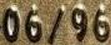

In [7]:
image = preprocess_image(image_path)
display(image)

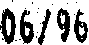

In [98]:
image = remove_background_simple(image_path)
display(image)

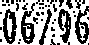

In [99]:
image = remove_background_adaptive(image_path)
display(image)

In [23]:
# 3. Предобработка и распознавание
pixel_values = processor(image, return_tensors="pt").pixel_values

In [24]:
generated_ids = model.generate(pixel_values)
recognized_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# 4. Вывод результата
print(f"Распознанные цифры: {recognized_text}")

Распознанные цифры: 06/96


In [41]:
# Извлечение уверенности
def get_text_with_confidence(outputs):
        
    # Получаем все токены (игнорируя <s> и </s>)
    tokens = outputs.sequences[0][1:-1]
    
    # Собираем результаты
    result_text = []
    confidences = []
    
    # Обрабатываем каждый токен
    for i, token in enumerate(tokens):
        # Получаем текстовое представление токена
        token_text = processor.decode([token], skip_special_tokens=True)
        
        # Получаем уверенность для этого токена
        confidence = torch.softmax(outputs.scores[i], dim=-1)[0, token].item()
        
        # Для каждого символа в декодированном токене добавляем уверенность
        for char in token_text:
            result_text.append(char)
            confidences.append(confidence)
    
    # Собираем полный текст
    full_text = ''.join(result_text)
        
    return full_text, confidences

In [42]:
# Генерация текста
outputs = model.generate(
    pixel_values,
    output_scores=True,
    return_dict_in_generate=True,
    max_length=50
)

# Результат
full_text, confidences = get_text_with_confidence(outputs)

# Проверка
print(f"Распознанный текст: '{full_text}'")
print(f"Длина текста: {len(full_text)}, Уверенностей: {len(confidences)}")
print("Соответствие символов и уверенностей:")
for char, conf in zip(full_text, confidences):
    print(f"'{char}': {conf:.1%}")

Распознанный текст: '06/96'
Длина текста: 5, Уверенностей: 5
Соответствие символов и уверенностей:
'0': 96.8%
'6': 96.8%
'/': 99.6%
'9': 100.0%
'6': 100.0%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.bar(recognized_text, confidences)
plt.title("Уверенность распознавания по символам")
plt.ylabel("Вероятность")
plt.ylim(0, 1)
plt.show()